Camera Calibration
1. Have the camera matrix and distortion coefficients been computed correctly and
checked on one of the calibration images as a test?

Camera Images are usually distorted especially the edges of the camera are bended. It is because the camera converts 2D images into 3D. We will use OpenCV chessboard camera calibration functions to get the distortion coefficient, camera matrix to undistort the road images using chessboard images. 
"object points", which are the actual (x, y, z) coordinates of the chessboard corners in the
world are obtained....
The chessboard is assumed to be fixed on the (x, y) plane at z=0, such that the object points are
the same for each calibration image.
Thus, *objp* is just a replicated array of coordinates, and *objpoints* is appended with a copy of it every time chessboard corners are successfully detected in a test image.
imgpoints are appended with the (x, y) pixel position of each of the corners in the image plane with
each successful chessboard detection. After that the output objpoints and imgpoints are used to compute the camera calibration and distortion coefficients using the cv2.calibrateCamera() function.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import deque
%matplotlib qt

In [2]:
def camera_calibration(img):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(img):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    img_size = (img.shape[1], img.shape[0])
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    return (ret, mtx, dist, rvecs, tvecs)

In [3]:
calibration_image_files = glob.glob("camera_cal/*")

In [4]:
ret, mtx, dist, rvecs, tvecs = camera_calibration(calibration_image_files)

Now we will use camera matrix and distortion coefficients to undistort the camera images.

In [5]:
%matplotlib inline

In [6]:
def img_undistort(img):
    
# Test undistortion on an image
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

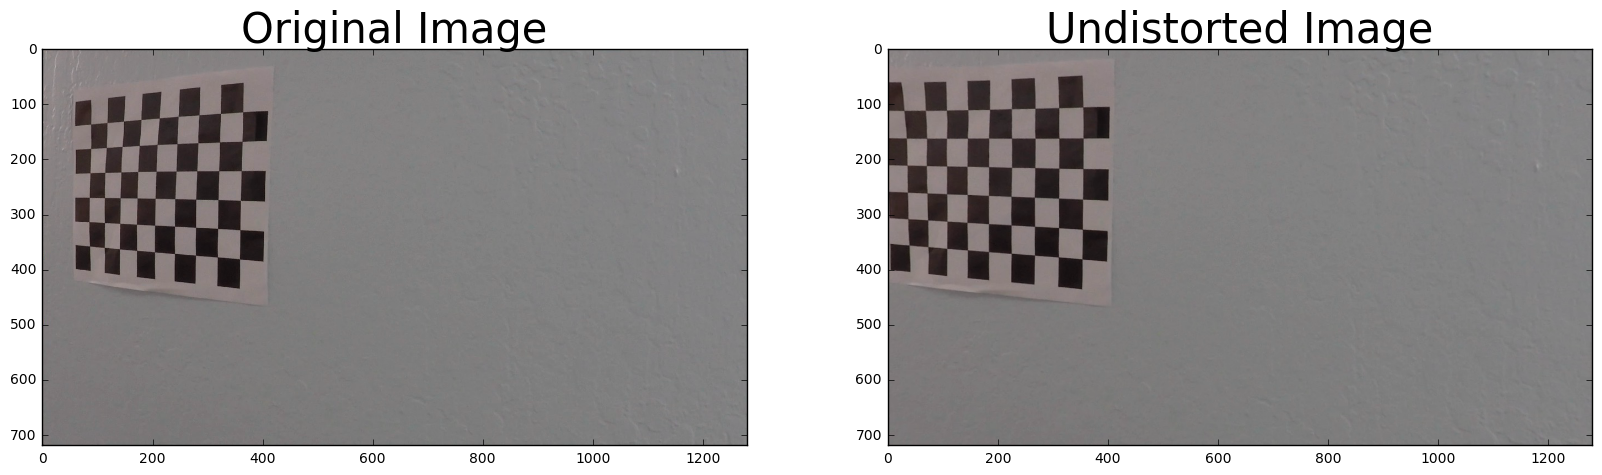

In [8]:
chess = cv2.imread('camera_cal/calibration19.jpg')
undistort_chess = cv2.undistort(chess, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(chess)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistort_chess)
ax2.set_title('Undistorted Image', fontsize=30)

1. Has the distortion correction been correctly applied to each image?
In the below you can find the undistorted image.

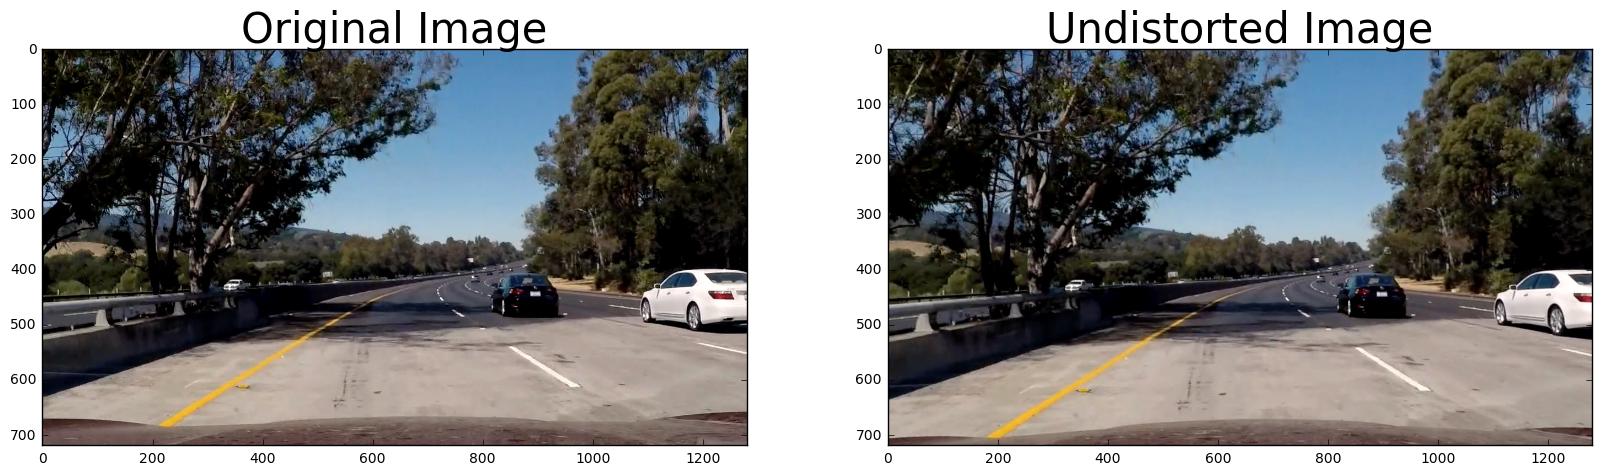

In [7]:
road = cv2.imread('test_images/test5.jpg')
road = cv2.cvtColor(road, cv2.COLOR_BGR2RGB)
undistort_road = cv2.undistort(road, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(road)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistort_road)
ax2.set_title('Undistorted Image', fontsize=30)

In [8]:
def histogram_equal(img):
    return cv2.equalizeHist(img)

In [9]:
def gaussian_blur(img, kernel_size=5):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [10]:
road.shape

(720, 1280, 3)

We have to get the gradients of the image in order to get edges and detect the lane lines. The fact that lane lines are vertical we can use Sobel operator in x or/and y direction in order to get the edges of the lane lines. Taking the gradient in the x-direction emphasizes edges closer to vertical and in the y-direction, edges closer to horizontal. As it can be seen that after appyling thresholded sobelx operator we obtained binary image but left lanes are missing under the yellow shade. That's why we have to change the colorspace in order to get the yellow lanes.

In [11]:
def hls_threshold(img, threshold = (180, 255)):
    
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls_img[:,:,2]
    s_channel = cv2.equalizeHist(s_channel)
    binary = np.zeros_like(s_channel)
    binary[(s_channel > threshold[0]) & (s_channel <= threshold[1])] = 1
    #plt.imshow(hls_img)
    return binary

In the below picture it can be seen that binary thresholded s_channel is not good at detecting the white channels. But binary thresholded sobelx can detect the white lines. It will be better to stack these two binary images to get the robust lane detection algorithm.

In [12]:
from PIL import Image

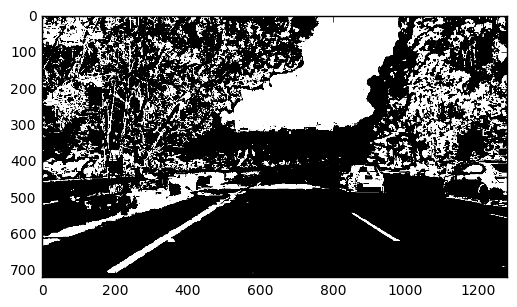

In [13]:
s_channel_img = hls_threshold(undistort_road)
plt.imshow(s_channel_img,cmap='gray')

In [14]:
def abs_sobel_thresh(img, orient='x', sobel_kernel = 3, thresh_min=50, thresh_max=255):
    
#You need to pass a single color channel to the cv2.Sobel() function, so first convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #gray = histogram_equal(gray)
#Calculate the derivative in the x-direction (the 1, 0 at the end denotes x-direction):
    #Calculate the derivative in the x-direction (the 1, 0 at the end denotes x-direction)
    if orient == 'x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        #Calculate the absolute value of the x-derivative
        abs_sobel = np.absolute(sobelx)
    if orient == 'y':
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        #Calculate the absolute value of the y-derivative
        abs_sobel = np.absolute(sobely)

#Calculate the absolute value of the x-derivative:
    #abs_sobel = np.absolute(sobelx)
#Convert the absolute value image to 8-bit:
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
#Create a binary threshold to select pixels based on gradient strength:
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    #plt.imshow(sxbinary, cmap='gray')
    return sobel_binary

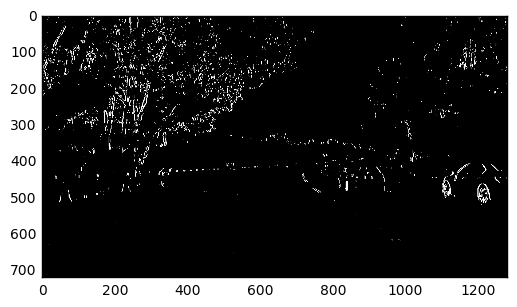

In [15]:
sobelx_img = abs_sobel_thresh(undistort_road)
plt.imshow(sobelx_img,cmap='gray')

In [16]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(50, 255)):
    # Calculate gradient magnitude
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #gray = histogram_equal(gray)
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Apply threshold
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    return mag_binary

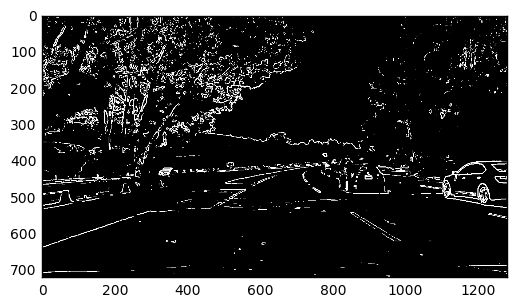

In [17]:
mag_thresh_img = mag_thresh(undistort_road)
plt.imshow(mag_thresh_img,cmap='gray')

In [18]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.7)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #gray = histogram_equal(gray)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

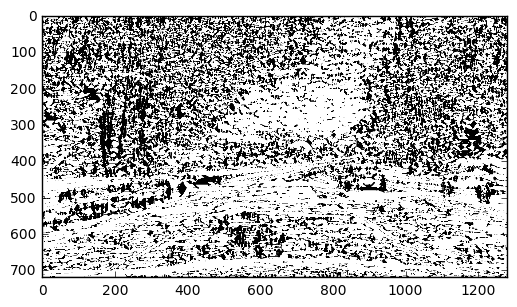

In [19]:
dir_threshold_img = dir_threshold(undistort_road)
plt.imshow(dir_threshold_img, cmap='gray')

In [20]:
def combined_thresh(img):
    abs_bin = abs_sobel_thresh(img, orient='x', thresh_min=50, thresh_max=255)
    mag_bin = mag_thresh(img, sobel_kernel=3, mag_thresh=(50, 255))
    dir_bin = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    hls_bin = hls_threshold(img, threshold=(170, 255))
    combined = np.zeros_like(dir_bin)
    combined[(abs_bin == 1 | ((mag_bin == 1) & (dir_bin == 1))) | hls_bin == 1] = 1     
    return combined

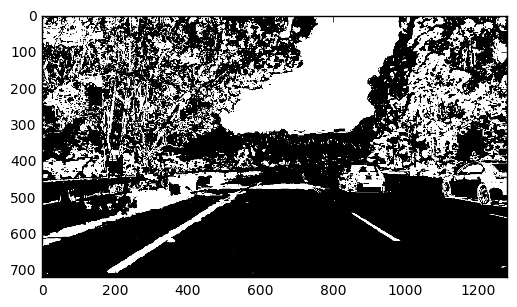

In [21]:
combined_thresh_img = combined_thresh(undistort_road)
plt.imshow(combined_thresh_img,cmap='gray')

In [22]:
def combine_color_grad(s_channel_binary, sobelx_binary):
# This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sobelx_binary), sobelx_binary, s_channel_binary))
# Combine the two binary thresholds
    combined_binary = np.zeros_like(sobelx_binary)
    combined_binary[(s_channel_binary == 1) | (sobelx_binary == 1)] = 1
    return combined_binary

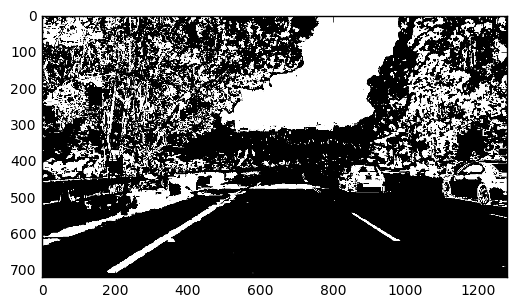

In [23]:
combined_binary_img = combine_color_grad(s_channel_img, sobelx_img)
plt.imshow(combined_binary_img, cmap='gray')

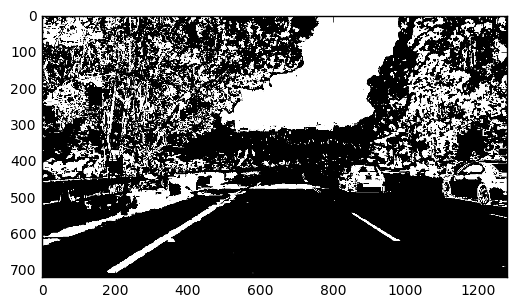

In [41]:
combined_binary_img = cv2.equalizeHist(combined_binary_img)
plt.imshow(combined_binary_img, cmap='gray')

In [42]:
def region_of_interest(image):
    bottom_left = (image.shape[1] * 0.15, image.shape[0])
    bottom_right = (image.shape[1] * 0.93, image.shape[0])

    top_left = (image.shape[1] * 0.4 , image.shape[0]/2)
    top_right = (image.shape[1] * 0.6 , image.shape[0]/2)
    
    
    white = np.zeros_like(image)
    points = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    cv2.fillPoly(white, points , 255)
    
    masked_image = cv2.bitwise_and(image, white)
    return masked_image

In [43]:
combined_binary_img.shape

(720, 1280)

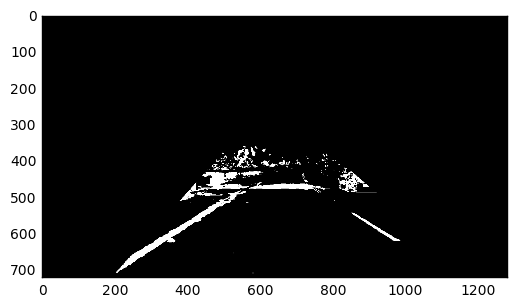

In [44]:
#plt.imshow(region_of_interest(combined_binary_img),cmap='gray')
plt.imshow(region_of_interest(combined_thresh_img),cmap='gray')

In [45]:
def warp(img):
    
    img_size = (img.shape[1],img.shape[0])
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],  #top-left
        [((img_size[0] / 6) - 10), img_size[1]],           #bottom-left
        [(img_size[0] * 5 / 6) + 60, img_size[1]],         #bottom-right
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])  #top-right
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    M = cv2.getPerspectiveTransform(src, dst)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

In [46]:
#binary_warp = warp(region_of_interest(combined_thresh_img))
binary_warp = warp((combined_thresh_img))

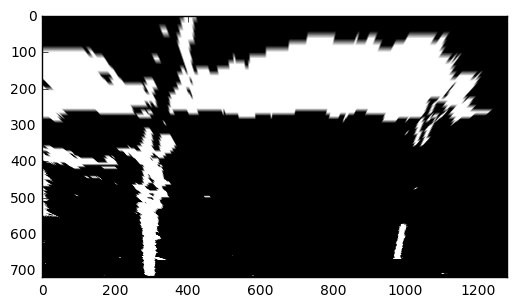

In [47]:
plt.imshow(binary_warp, cmap='gray')

In [48]:
def histogram_filter(binary_warped):
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    #plt.plot(histogram)
    return histogram

/home/rahul/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


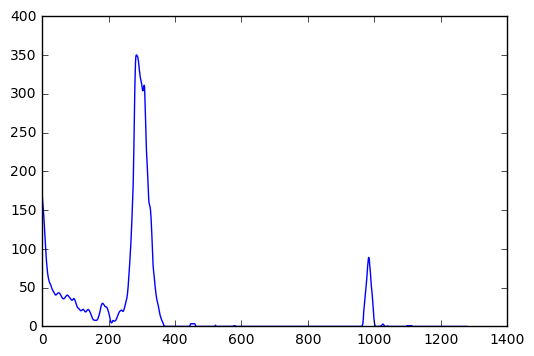

In [49]:
plt.plot(histogram_filter(binary_warp))

In [50]:
def three_channel_binary(binary_warp):
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warp, binary_warp, binary_warp))*255
    return out_img

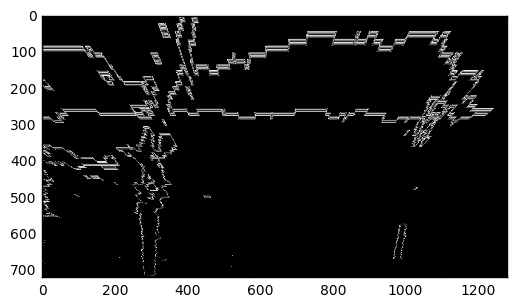

In [51]:
plt.imshow(three_channel_binary(binary_warp))

In [52]:
def peaks(histogram, binary_warped):
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])  #co-ordinate of left lane
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint  #co-ordinate of right lane 
# Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)  #height of the sqaure
# Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()  #arrays with white pixels
    nonzeroy = np.array(nonzero[0])    #y-arrays with white pixels
    nonzerox = np.array(nonzero[1])    #x-arrays with white pixels
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    return (nonzeroy, nonzerox, window_height, leftx_current, rightx_current, midpoint)

In [53]:
# Choose the number of sliding windows
nwindows = 9
#peaks(histogram_filter(binary_warp), binary_warp)

In [54]:
nonzeroy, nonzerox, window_height, leftx_current, rightx_current, midpoint = peaks(histogram_filter(binary_warp), binary_warp)

/home/rahul/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [55]:
# Set the width of the windows +/- margin
margin = 100 #200 is the width of the window
# Set minimum number of pixels found to recenter window
minpix = 50
def sliding_window(binary_warped, leftx_current, rightx_current, window_height, nonzeroy, nonzerox):
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return (leftx, lefty, rightx, righty)


In [56]:
leftx, lefty, rightx, righty = sliding_window(binary_warp, leftx_current, rightx_current, window_height, nonzeroy, nonzerox)

In [57]:
def curvature(leftx,rightx,lefty,righty):
    
    #ploty = np.linspace(0, 719, num=720)# to cover same y-range as image

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    y_eval = 719 # 720p video/image, so last (lowest on screen) y index is 719

# Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    return (left_curverad, right_curverad)

In [58]:
curvature(leftx,rightx,lefty,righty)

(6576.7194062742192, 1820.2179689360528)

In [59]:
def get_poly(lefty, leftx, righty, rightx):
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return (left_fit,right_fit)
    

In [60]:
(left_fit,right_fit) = get_poly(lefty, leftx, righty, rightx)

In [61]:
def fill_shade(left_fit,right_fit, binary_warped):
# Fit a second order polynomial to each
    #left_fit = np.polyfit(lefty, leftx, 2)
    #right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    fity = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    fit_leftx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
    fit_rightx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
# Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([fit_leftx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([fit_rightx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    return color_warp

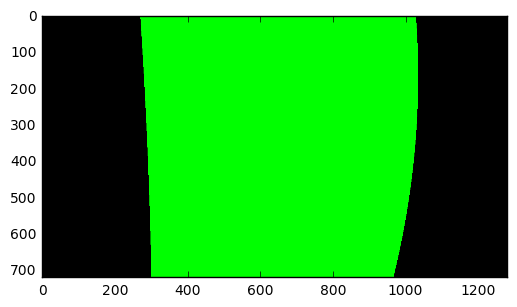

In [62]:
plt.imshow(fill_shade(left_fit,right_fit, binary_warp))

In [63]:
def unwarp(img):
    
    img_size = (img.shape[1],img.shape[0])
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],  #top-left
        [((img_size[0] / 6) - 10), img_size[1]],           #bottom-left
        [(img_size[0] * 5 / 6) + 60, img_size[1]],         #bottom-right
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])  #top-right
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    M = cv2.getPerspectiveTransform(dst, src)
    
    newwarped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return newwarped

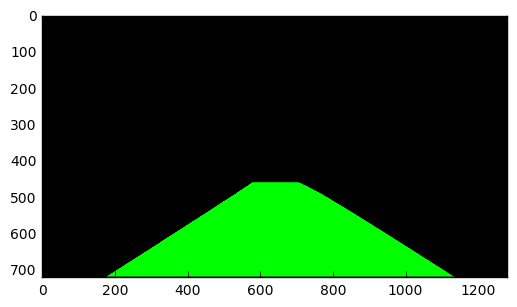

In [64]:
unwarped_shaded = unwarp(fill_shade(left_fit,right_fit, binary_warp))
plt.imshow(unwarped_shaded)

In [65]:
def shaded_image(dst, newwarp):
    return cv2.addWeighted(dst, 1, newwarp, 0.3, 0)

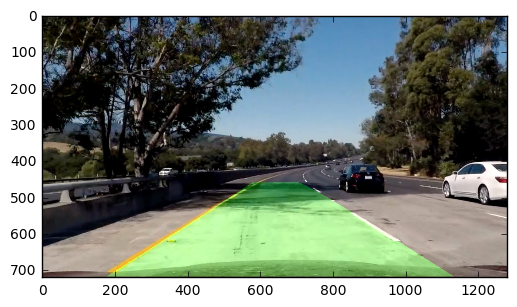

In [66]:
plt.imshow(shaded_image(undistort_road, unwarped_shaded))

In [67]:
class Line:
    # Set the width of the windows +/- margin
    margin = 100 #200 is the width of the window
# Set minimum number of pixels found to recenter window
    minpix = 50

    
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.left_fit = None
        self.right_fit = None
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.polyA_left = deque(maxlen=5)
        self.polyB_left = deque(maxlen=5)
        self.polyC_left = deque(maxlen=5)
        
        self.polyA_right = deque(maxlen=5)
        self.polyB_right = deque(maxlen=5)
        self.polyC_right = deque(maxlen=5)
        
        #self.left_fit = None
        #self.right_fit = None
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        #self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        #self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        #self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def undetected_frame(self, binary_warped):
        if self.detected == False:
            histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
            window_height = np.int(binary_warped.shape[0]/nwindows)
                # Identify the x and y positions of all nonzero pixels in the image
            nonzero = binary_warped.nonzero()  #arrays with white pixels
            nonzeroy = np.array(nonzero[0])    #y-arrays with white pixels
            nonzerox = np.array(nonzero[1])    #x-arrays with white pixels
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint  #co-ordinate of right lane 
            rightx_current = rightx_base
            leftx_current = leftx_base
            left_lane_inds = []
            right_lane_inds = []
            for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
                win_y_low = binary_warped.shape[0] - (window+1)*window_height
                win_y_high = binary_warped.shape[0] - window*window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
            return (left_fit, right_fit)
            #return (leftx,lefty,rightx,righty)
                
    def detected_frame(self, binary_warped,left_fit,right_fit):
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
            # Again, extract left and right line pixel positions

        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        return (left_fit,right_fit)            

In [71]:
line = Line()

In [72]:
#line.undetected_frame(binary_warp)

In [73]:
def process_image(image):
        
    undistorted = cv2.undistort(image, mtx, dist, None, mtx)
        
    combined_binary_img = combined_thresh(undistorted)
    binary_warp = warp(combined_binary_img)    
        #nonzeroy, nonzerox, window_height, leftx_current, rightx_current, midpoint = peaks(histogram_filter(binary_warp),
        #                                                                               binary_warp)
        #leftx, lefty, rightx, righty = sliding_window(binary_warp,
        #                                              leftx_current, rightx_current, window_height, nonzeroy, nonzerox)
        #(left_fit,right_fit) = get_poly(lefty, leftx, righty, rightx)
    if line.detected == True:
        nonzero = binary_warp.nonzero()
        if nonzero[1] == []:
            line.detected = False
        else:
            line.left_fit = line.detected_frame(binary_warp, line.left_fit, line.right_fit)[0]
            line.right_fit = line.detected_frame(binary_warp, line.left_fit, line.right_fit)[1]
    
    if line.detected == False:
        
        line.left_fit = line.undetected_frame(binary_warp)[0]
        line.right_fit = line.undetected_frame(binary_warp)[1]
        line.detected = True
        #print(line.left_fit,line.right_fit)
    line.polyA_left.append(line.left_fit[0])
    line.polyB_left.append(line.left_fit[1])
    line.polyC_left.append(line.left_fit[2])
    
    A_average_poly_left = sum(line.polyA_left) / len(line.polyA_left)
    B_average_poly_left = sum(line.polyB_left) / len(line.polyB_left)
    C_average_poly_left = sum(line.polyC_left) / len(line.polyC_left)
    
    line.polyA_right.append(line.right_fit[0])
    line.polyB_right.append(line.right_fit[1])
    line.polyC_right.append(line.right_fit[2])
    
    A_average_poly_right = sum(line.polyA_right) / len(line.polyA_right)
    B_average_poly_right = sum(line.polyB_right) / len(line.polyB_right)
    C_average_poly_right = sum(line.polyC_right) / len(line.polyC_right)
    
    fity = np.linspace(0, binary_warp.shape[0]-1, binary_warp.shape[0])
    fit_leftx = A_average_poly_left*fity**2 + B_average_poly_left*fity + C_average_poly_left
    fit_rightx = A_average_poly_right*fity**2 + B_average_poly_right*fity + C_average_poly_right
    warp_zero = np.zeros_like(binary_warp).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
# Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([fit_leftx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([fit_rightx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    #print (line.polyA)
    return color_warp

In [74]:
road2 = cv2.imread('test_images/test6.jpg')
road2 = cv2.cvtColor(road, cv2.COLOR_BGR2RGB)

/home/rahul/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:42: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


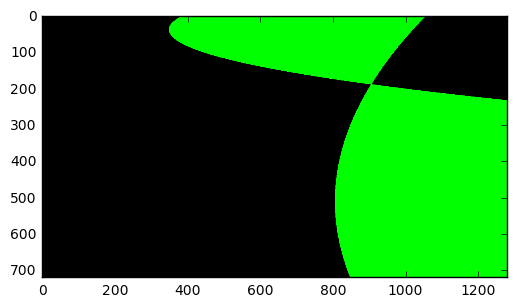

In [75]:
plt.imshow((process_image(road)))
#(process_image(road2))

In [237]:
line.detected

True

In [60]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [61]:
output = 'project.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project.mp4
[MoviePy] Writing video project.mp4


100%|█████████▉| 1260/1261 [09:30<00:00,  2.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project.mp4 

CPU times: user 33min 5s, sys: 48.1 s, total: 33min 53s
Wall time: 9min 32s


In [61]:
print (line.recent_xfitted)

[]
